## Look at number of neurons that participate into ripple events

In [59]:
import pandas as pd
import sys
import pickle
sys.path.append("D:/ryanh/github/ripple_analyses")
from functions import *
from matplotlib import pyplot as plt
import numpy as np

from tqdm import tqdm

import itertools
# from scipy.ndimage import gaussian_filter1d
# import multiprocessing
# from joblib import Parallel, delayed
# import glob as glob
# from scipy.stats import poisson,zscore
# import seaborn as sns
# import matplotlib.ticker as ticker
# from scipy import signal
# from itertools import groupby


In [6]:
project_path = 'F:/Projects/PAE_PlaceCell/'
analysis_path = project_path+'analysis/'
data_path = project_path+'ProcessedData/'          
save_path = analysis_path+"ripple_modulation/"
df_swr = pd.read_csv(analysis_path+'swr_data/post_processed/swr_df.csv')
df_cell_class = pd.read_csv(analysis_path+'cell_recruitment/processed/pyr_int_df.csv')

spikes_path = 'F:/Projects/PAE_PlaceCell/analysis/spikes'

In [84]:
def get_recruted(spikes,df_swr,session):
    # loop through each ripple and each cell to see if the ripple recruited each cell
    recruited = np.zeros([len(df_swr[df_swr.session == session]),spikes.shape[0]])
    for i,event in enumerate(df_swr[df_swr.session == session].itertuples()):
        for j,s in enumerate(spikes):
            recruited[i,j] = any((s >= event.start_time) & (s <= event.end_time))

    # fraction of all recorded neurons participating in each ripple        
    recruit_frac = recruited.sum(axis=1) / spikes.shape[0]     
    
    return recruit_frac

def add_group_affiliation(df):
    control=('RH13','RH14','LS21','LS23','LE2821','LE2823','LEM3116','LEM3120','LEM3216')
    pae=('RH11','RH16','LS17','LS19','LE2813','LEM3124','LEM3206','LEM3246')

    df['group'] = np.ones_like(df.session)

    regstr = '|'.join(control)
    idx = df['session'].str.upper().str.contains(regstr)    
    df.loc[idx,'group'] = 'control'

    regstr = '|'.join(pae)
    idx = df['session'].str.upper().str.contains(regstr)    
    df.loc[idx,'group'] = 'pae'
    return df

In [110]:
recruit_frac = []
area = []
session_ = []
n_ripples = []
for session in tqdm(df_swr.session.unique()):

    spikes = np.load(
        os.path.join(spikes_path,session+'.npy'),
        allow_pickle=True
    )

    # maybe multiple areas in a single recording session
    for area_ in df_cell_class[df_cell_class.session == session].area.unique():
        # pull out cells for current session
        cur_spikes = spikes[df_cell_class[df_cell_class.session == session].area==area_]
        # restrict cells to those with >= 100 spikes
        n_spikes = [len(s) for s in cur_spikes]
        cur_spikes = cur_spikes[np.array(n_spikes) >= 100]
        # calculate the fraction of active units per ripple
        recruit_frac.append(get_recruted(cur_spikes,df_swr,session))
        # add number of ripples
        n_ripples.append(np.repeat(len(df_swr[df_swr.session == session]), len(df_swr[df_swr.session == session])))        
        # add area ID
        area.append([area_]*len(df_swr[df_swr.session == session]))
        # add session ID
        session_.append([session]*len(df_swr[df_swr.session == session]))


100%|██████████████████████████████████████████████████████████████| 189/189 [02:06<00:00,  1.49it/s]


In [109]:

n_ripples[-1]

array([11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11])

In [ ]:
df = pd.DataFrame()

df['session'] = list(itertools.chain(*session_))
rat = [s.split('_')[0] for s in df.session]
df['rat']=rat
df = add_group_affiliation(df)
df['area'] = list(itertools.chain(*area))
df['recruit_frac'] = list(itertools.chain(*recruit_frac))
df['n_ripples'] = list(itertools.chain(*n_ripples))

display(df)
df.to_csv('F:\Projects\PAE_PlaceCell\analysis\ripple_modulation\post_processed\recruit_frac_df.csv')

In [86]:
tex_fonts = {
#     # Use LaTeX to write all text
#     "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}
plt.style.use('seaborn-paper')
plt.rcParams.update(tex_fonts)

%config InlineBackend.figure_format = 'retina'

fig_save_path = 'D:/ryanh/GoogleDrive/school_work/UNM/Lab/Projects/Dissertation/dissertation/inkscape_figs/ripple_recuitment/'

In [87]:
group_colors = {"controlca1": '#222629ff',
                "controlca3": '#103876ff',
                'paeca1': '#ff5240ff',
                'paeca3': '#ebad46ff'} 
def ecdf(x):
    xs = np.sort(x)
    ys = np.linspace(0,1,len(xs))
    return xs, ys


def plot_ecdf(var,df,area,ax,group_colors):
    for rat in pd.unique(df.rat):
        y = df[(df.rat == rat) & (df.area == area)]
        if y.empty == False:
            xs, ys = ecdf(y[var])
            ax.plot(xs,ys,color=group_colors[y.group.iloc[0]+y.area.iloc[0]],linewidth=.5)

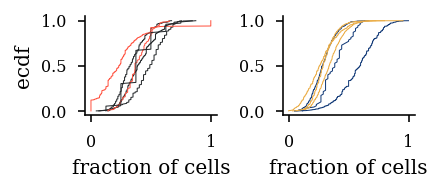

In [119]:
df2 = df[df.n_ripples > 50]


fig, axs = plt.subplots(1,2, figsize=set_size('thesis', fraction=.5, subplots=(1, 2)), edgecolor='k')
fig.subplots_adjust(hspace = 1.2, wspace=0.5)
axs = axs.ravel()

ax_num = [0,1]
plot_ecdf('recruit_frac',df2,'ca1',axs[ax_num[0]],group_colors)
axs[ax_num[0]].set_xlabel('fraction of cells')
axs[ax_num[0]].set_ylabel('ecdf')

plot_ecdf('recruit_frac',df2,'ca3',axs[ax_num[1]],group_colors)
axs[ax_num[1]].set_xlabel('fraction of cells')

for i in range(2):
    right_side = axs[i].spines["right"]
    right_side.set_visible(False)
    top_side = axs[i].spines["top"]
    top_side.set_visible(False)
    
plt.savefig(os.path.join(fig_save_path,'recruit_frac.svg'),dpi=300,bbox_inches='tight')    

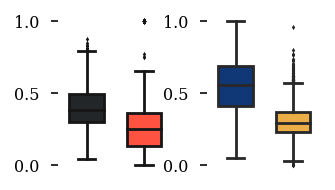

In [120]:
import seaborn as sns
fig, axs = plt.subplots(1,2, figsize=set_size('thesis', fraction=.4, subplots=(1, 1)), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=.3)
axs = axs.ravel()

sns.set_palette(sns.color_palette([group_colors['controlca1'],group_colors['paeca1']]))
g=sns.boxplot(x="group", y="recruit_frac", data=df2[(df2.area=='ca1')],
            width=.6,ax=axs[0],saturation=1,fliersize=.5)
axs[0].axes.get_xaxis().set_ticks([])
g.set(xlabel=None)
g.set(ylabel=None)


sns.set_palette(sns.color_palette([group_colors['controlca3'],group_colors['paeca3']]))
g=sns.boxplot(x="group", y="recruit_frac", data=df2[(df2.area=='ca3')],
            width=.6,ax=axs[1],saturation=1,fliersize=.5)
axs[1].axes.get_xaxis().set_ticks([])
g.set(xlabel=None)
g.set(ylabel=None)

axs[0].set_ylim(min(axs[0].get_ylim()[0],axs[1].get_ylim()[0]),max(axs[0].get_ylim()[1],axs[1].get_ylim()[1]))
axs[1].set_ylim(min(axs[0].get_ylim()[0],axs[1].get_ylim()[0]),max(axs[0].get_ylim()[1],axs[1].get_ylim()[1]))
 
sns.despine(trim=True, left=True, bottom=True)
plt.savefig(os.path.join(fig_save_path,'recruit_frac_box.svg'),dpi=300,bbox_inches='tight')